# Mobility Data Analysis
1. Scoping
2.  Preprocress the data
3. Explolatory Data Analysis (EDA)
4. Generate user trips and other user attributes
5. Perfom analysis of user data to generate individual level metrics
6. Generate aggregate metrics such as OD

# Project Scoping

In [ ]:
"""Your source code looks good but your interpretation are not clear. Please check the proposed 
solutions from the lecturer to get more knowledge.

You were supposed to write your group members names 
"""

In [40]:
# import module
from tabulate import tabulate
  
# assign data
mydata = [{"Average number of trips per day", "For each individual, the mean number of trips they take everyday"}, 
          {"Average location per days", "for each individu, we compute the number of unique locations visited per day"}, 
          {"Radius of gyration", "it is the maximum distance a user travelled"}, 
          {"Usage days", "number of days a user was activive"}]
  
# create header
head = ["Exact metric definition", "Metric name"]

  
# display table
print(tabulate(mydata, headers=head, tablefmt="fancy_grid"))

╒══════════════════════════════════════════════════════════════════════════════╤═════════════════════════════════╕
│ Exact metric definition                                                      │ Metric name                     │
╞══════════════════════════════════════════════════════════════════════════════╪═════════════════════════════════╡
│ For each individual, the mean number of trips they take everyday             │ Average number of trips per day │
├──────────────────────────────────────────────────────────────────────────────┼─────────────────────────────────┤
│ for each individu, we compute the number of unique locations visited per day │ Average location per days       │
├──────────────────────────────────────────────────────────────────────────────┼─────────────────────────────────┤
│ it is the maximum distance a user travelled                                  │ Radius of gyration              │
├──────────────────────────────────────────────────────────────────────────────┼

# Expected Output

- **Barplot** 
- **Scatterplot**
- **Distribution plot** to see the distribution of variable
- **Heatmap**
- **Correlation matrix** to see relation between variables
- **Data frame**
- **Spark dataframe**
- **Statistics table** which shown the different statistics of the movements of users
- **Number of days** we return the number of activities days of users

# Instructions
1. Please fill out all the places with "YOUR CODE HERE" with your code.
2. Fill in with your functions, in places where I ask you to do so.
3. Please answer all non-code questions where 

#  Python setup
Heree, we import all the required Python packages. In order to use, 
any other module which wasnt ```pip``` installed, such as ```mob_data_utils```,
you  can do the following:
```sys.append(full_path_to_module)```

In [6]:
# utility libraries
import os
from pathlib import Path
from functools import wraps
import time
from datetime import datetime
import random

# data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Apache Spark Modules
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import col,udf
from pyspark.sql.types import *
from statistics import * 

# plotting library
import seaborn as sns
sns.set_style("white")
sns.set_context("poster", font_scale=1.25, rc={"lines.linewidth":1.25, "lines.markersize":8})

# local libraries (e.g., mob_data_utils)
# since mob_data_utils.py is in this dir
import mob_data_utils as ut
import geopandas
import warnings
warnings.filterwarnings("ignore")

# Setup working directories
Its also important to setup commonly used diretories such as where you will be saving data

In [2]:
# We can use CAPS for these variables since they are constants
BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR.joinpath('data')
OUTPUTS_DIR = BASE_DIR.joinpath('outputs')

In [3]:
# Setup global parameters and variables
MISC_PROCESSING_PARAMS = {'distance_threshold': 2, 'min_unique_locs': 2,'datetime_col': 'datetime',
                        'userid': 'user_id','x': 'lon', 'y': 'lat'}

In [4]:
MISC_PROCESSING_PARAMS.get('x')

'lon'

In [5]:
MISC_PROCESSING_PARAMS.get('userid')

'user_id'

# Data preprocessing.
Often, after all the data has been  acquired, thee next step is to do some preprocessing on the raw data. 
The objectives of this task will vary depending on the data analysis goals but some of them include following:
- **Sanitize the data:** this data cleaning has to be done carefully to avoid introducing errors but its often a necessary step. It can involve dropping some unnecessary variables/columns. Renaming some columns to something which makes more sense. Dropping some observations. For instance, in this analysis where location and time-stamp is important, dropping all observations with no time-stamp and no location is required.
- **Create new variables:**. If necessary, this is also the time transform some variables from a format which is not convinient for your analysis. For instance, converting string time variables to datetime aware variables.
- **Combine datasets:** If you have more than one dataset, during preprocessing, you can also combine several datasets into one. For instance, we have the CDR transations which have no location details. We bring in the location details from another file.
- **Filtering based on columns and observations:** This can be done through any of the stages mentioned above but its worth mentioning that often, you may drop some columns which arent useful for your analysis. Also, you may drop some observations based on some conditions depending on your analysis needs.

Unlike in other data collection domains such as surveys where you can have standard data processing steps, in the data science space where your dataset can be anything, there are no hard and fast rule for preprocessing and data cleaning. It will be a case by case basis depending on your analysis goals. Also, preprocessing isnt necessarily a linear process: depending on what results you get downstream, you can go back and modify the preprocesisng steps. In this project, we have the ```preprocess_cdrs_using_spark``` which takes raw cdrs and saves to a CSV a processed dataset. Alternatively, we can return a Spark DataFrame.

In [6]:
def rename_sdf(df, mapper=None):
    ''' Rename column names of a dataframe
        mapper: a dict mapping from the old column names to new names
        Usage:
            df.rename({'old_col_name': 'new_col_name', 'old_col_name2': 'new_col_name2'})
            df.rename(old_col_name=new_col_name)
    '''
    for before, after in mapper.items():
        df = df.withColumnRenamed(before, after)
    
    return df

In [7]:
# ADD YOUR PROCESS FUNCTION HERE
def preprocess_cdrs_using_spark(file_or_folder=None, number_of_users_to_sample=None,
                                output_csv=None, date_format='%Y%m%d%H%M%S',
                                debug_mode=True, loc_file=None, save_to_csv=False,
                                userid_col="user_id"):
    """
    In this function, we perfom some basic preprocessing such as below:
    1. rename columns
    2. change some data types
    3. Add location details
    Eventually, we will sample the data to use for our analysis
    :param data_folder:
    :param output_csv_for_sample_users:
    :return:
    """

    # ==============================
    # LOAD DATA
    # ==============================
    # create SparkSession
    spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Assignement Of Louis") \
    .getOrCreate() 
    # read data with spark and ensure you set header to True
    df = spark.read.csv(file_or_folder ,header=True)
    # repartition to speed up
    df = df.repartition(10)

    # if just testing/debugging, pick only a small subset of the dataset
    # for instance, 0.01 percent of the data
    # by using the sample function of spark
    if debug_mode:
        dfs = df.sample(fraction = 0.1) 
        df = dfs

    # ==================================================
    # RENAME, DROP COLUMNS, ADD DATETIME AND DROP NULLS
    # ===================================================
    # rename columns to remove space the names
    # replace space with underscore
    cols_to_rename = {}
    for c in df.columns:
        if " " in c:
            cols_to_rename[c] = c.replace(" ", "_")

    #  now call the rename_sdf function
    # using df and the dictionary above
    df = rename_sdf(df, mapper=cols_to_rename)

    # this approach is also okay but you are hardcoding the column names
    # so, lets avoid hardcoding at all times
    #     df = (df.withColumnRenamed("cdr datetime", "cdrDatetime")
    #         .withColumnRenamed("last calling cellid", "cellId")
    #         .withColumnRenamed("call duration", "cellDuration"))

    # change the column "last_calling_cellid" to just cell_id
    df = df.withColumnRenamed("last_calling_cellid","cell_id") 
    # drop the cdr_type and call_duration because we dont really need them
    df = df.drop("cdr type","call_duration") 
    # lets make sure we don't have any values in the user_id
    # and cdr_datetime columns
    # use spark filter() function and isNotNull() in a nested
    # fashion to achieve this
    df = df.filter(df['user_id'].isNotNull()) 
    df = df.filter(df.cdr_datetime.isNotNull())

    # Use Spark UDF to add date and datetime
    add_datetime = udf(lambda x: datetime.strptime(x, date_format), TimestampType())
    add_date = udf(lambda x: datetime.strptime(x, date_format), DateType())


    # create timestamp and date column
    df = df.withColumn('datetime', add_datetime(col('cdr_datetime')))
    df = df.withColumn('date', add_date(col('cdr_datetime'))) 

    # ==================================================
    # ADD LOCATION THROUGH JOIN
    # ===================================================
    # Lets merge with location details using cellId from CDRs and also
    # cellID on the other
    # read pandas dataframe of location details
    dfLoc = pd.read_csv(loc_file)
    # remove duplicates from the cell_id column to make sure we only
    # unique cell_ids.Use the drop_duplicates() in pandas
    dfLoc = dfLoc.drop_duplicates(subset='cell_id')
    # create spark dataframe from the pandas dataframe
    # using the function createDataFrame from the SparkSession object
    # and the pandas DataFrame created above
    sdfLoc = spark.createDataFrame(dfLoc)

    # join the cdrs dataframe with the location dataframe
    # When using the join function, make sure you choose the option which allows
    # to keep all records on the cdrs side which match with records on the right.
    # please use "inner"
    # best option here. Check the docs for details:
    # https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame
    df = df.join(sdfLoc,on='cell_id',how = "inner")

    # Drop all records which didn't find a match in the location file because we cant do this analysis
    # without location. There are several ways to do this. For instance, you can drop all rows where
    # use spark filter and condition set to cell_id isNotNull()
    df = df.filter(df.cell_id.isNotNull()) 
    # ==================================================
    # SAMPLE USERS
    # ===================================================
    # first, create a list of unique user user_ids
    # using the distinct() function on the userid_col
    all_users =  df.select(userid_col).distinct().collect() 

    # randomly select the required number of users
    # using the random.choices() function
    random_userid_list = [i[userid_col] for i in random.choices(all_users, k=number_of_users_to_sample)]

    # Now, for each of the selected users, leets get their data
    # select only our random user data using spark filter
    # use df.filter(). Inside it, use the isin() function on the
    # userid column
    dfu = df.filter(df['user_id'].isin(random_userid_list))

    # save to CSV if necessary
    if save_to_csv:
        dfu.coalesce(1).write.csv(path=output_csv, header=True)
    else:
        return dfu


In [52]:
# Use DATA_DIR and joinpath as its been used above to create
# full path for simulated_cdrs and loc file
loc_file =  "/home/user/Desktop/big data analytic/simulated_locs.csv"
cdrs_dir =  "/home/user/Desktop/big data analytic/simulated_cdrs"
num_users = 1000
debug = True

# call preprocess_cdrs_using_spark here
# use cache() at the end of the like this preprocess_cdrs_using_spark.cache()
# Learn about what cache does using spark here:
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.cache.html#pyspark.sql.DataFrame.cache
dfu = preprocess_cdrs_using_spark(file_or_folder=str(cdrs_dir), number_of_users_to_sample=num_users,
                                date_format='%Y%m%d%H%M%S',debug_mode=False, 
                                  loc_file=loc_file, save_to_csv=False).cache()

In [53]:
dfu.show()

+-------+----------------+--------------+-------------------+-------------------+----------+-------+------------------+------------------+
|cell_id|        cdr_type|  cdr_datetime|            user_id|           datetime|      date|site_id|               lat|               lon|
+-------+----------------+--------------+-------------------+-------------------+----------+-------+------------------+------------------+
|34821.0|    MoCallRecord|20180709082443|7261062279775109855|2018-07-09 08:24:43|2018-07-09|   S224|         -8.528478|         26.743777|
|34821.0|    MoCallRecord|20180706093149|7261062279775109855|2018-07-06 09:31:49|2018-07-06|   S224|         -8.528478|         26.743777|
|34821.0|OutGatewayRecord|20180706143359|7261062279775109855|2018-07-06 14:33:59|2018-07-06|   S224|         -8.528478|         26.743777|
|34821.0|    MoCallRecord|20180712164613|7261062279775109855|2018-07-12 16:46:13|2018-07-12|   S224|         -8.528478|         26.743777|
|34821.0|    MoCallRecord|2

# Explolatory Data Analysis (EDA)
Whether the end result of your project is to produce a statistical report or 
to build a prediction model to be put in production, EDA is an essential stage in any data science project. EDA can be defined as 
the process of performing initial investigations on data so as to discover patterns,to spot anomalies,
to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.
It is a good practice to understand the data first and try to gather as many insights from it. 
EDA is all about making sense of data before using the data for the intended use (e.g., build ML models, perfom statisitcal analysis). 

Again, there arent hard and fast rules on how to perfom EDA but some of the specific quesitons you would like to answer are as folloes:
- For each variable in the data, whats its distribution? Is it skewed? Whats its data type? Is it an approapriate  data type fopr my analysis. Are there any outliers?
- Whats the relationship between variables?

In this project, we will use the ```explore_data``` and explore what functions SPark has for basic EDA.

In [115]:
# ADD YOUR EXPLORE DATA FUNC HERE
def explore_data_with_spark(df=None, output_plot_file=None, output_heatmap=None):
    """
    Lets do a quick exploration of the data by generating the following:
    1. Number of days in the data
    2. User call count stats
    3. Weekday and hour calling patterns
    """
    # =====================================
    # CALCULATE THE NUMBER OF DAYS IN DATA
    # =====================================

    # use relevant spark function to generate
    # a list of unique dates, recall that the date
    # column is 'date
    dates_rows = df.select('date').distinct().collect() 
    # sort the dates using sorted() function
    sorted_dates = sorted(dates_rows)  
    # use list indexing to get the first element and last
    # element from the sorted list, substract them to get
    # time difference
    diff = sorted_dates[-1]['date']-sorted_dates[0]['date']
    # use days function to get the number of days
    num_days = diff.days
    # =====================================
    # GENERATE WEEKDAY AND HOUR CALL COUNT
    # =====================================

    # define UDF to calculate hour and weekday
    # for weekday use weekday() function while
    # for hour, use hour()
    add_hr = udf(lambda x :x.hour)              # Define Spark udf to get hour from the datetime column
    add_wkday = udf(lambda x: x.weekday())         # Define Spark udf to get hour from the datetime column
    # create a dictionary with keys as the weekday integers while the values
    # are the weekday name
    day_dict = {'0':'Monday', '1':'Tuesday', '2':'Wednesday', '3':'Thursday', '4':'Friday', '5':'Saturday','6':'Sunday'}

    # add hour column, lets call it 'hr
    # also add weekday column, we call it 'wkday'
    df = df.withColumn('hr',add_hr(col('datetime')))

    df = df.withColumn('wkday',add_wkday(col('date')))

    # create pandas DataFrame from Spark DataFrame above using toPandas()
    pdf =  df.groupBy('wkday','hr').count().toPandas()
    # use the Pandas.Series.map() function on the "wkday" column to convert
    # wkday as numbers to week day names and create  new column for weekday name
    # Lets call that column 'weekDay'
    pdf['weekDay']=pdf['wkday'].map(lambda x: day_dict[x])
    # drop the "wkday" column now
    pdf = pdf.drop("wkday", axis = 1)
    pdf = pdf.pivot(index='weekDay', columns='hr', values='count')

    # create and save heatmap
    # use plt.figure() to create figure with your chosen size
    plt.figure(figsize = (7,7))
    # use sns.heatmap() function to create heatmap using the Pandas DataFrame, pdf
    sns.heatmap(pdf)
    # save the figure to file
    plt.savefig(output_heatmap)

    # =====================================
    # NUMBER OF CALLS FOR EACH USER
    # =====================================
    # Use Spark groupBy function to group user and count number of events
    # convert resulting spark dataframe to pandas in the samee line of code
    df_grp_user =  df.groupBy('user_id').count().toPandas()

    # create a distribution plot of user call count using
    # seaborn distplot() function and save the figure
    # first, use plt.figure() to create new figure environment
    # Next, create the plot and then finally save it
    plt.figure(figsize= (5,5))
    sns.distplot(df_grp_user)                                                        # A refaire
    plt.savefig(output_plot_file)
    plt.show()

    # report average number calls per day for each user
    # first use spark groupBy on user_id and day, then
    # convert that object to pandas dataframe using toPandas()
    # function
    df_grp_day = df.groupby('user_id','date').count().toPandas()

    # get mean and median
    mean =  df_grp_day['count'].mean()
    median = df_grp_day['count'].median()

    # return results like this mean, median, number of days
    return mean, median, df_grp_day['date'].nunique()

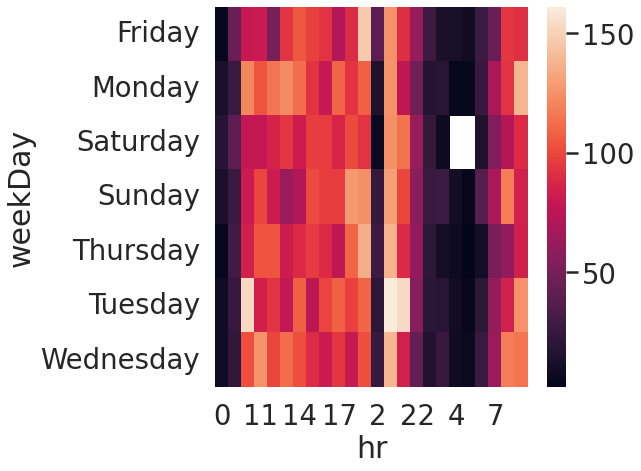

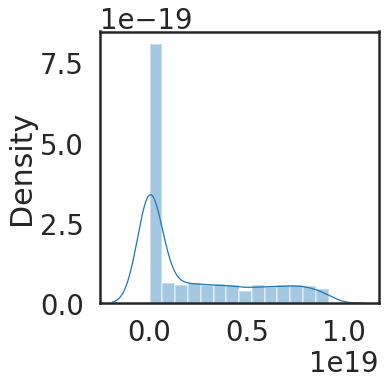

(2.9798657718120807, 2.0, 15)

In [116]:
explore_data_with_spark(df=dfu, output_plot_file='p.png', output_heatmap='c.png')

## Project Task

### Generate more summary statistics
Please complete the function below.

In [110]:
def summary_stats_for_user_events(spark_df, out_stats):
    """
    In this function, the goal is to take a big Spark
    DataFrame, group users and count each users events, 
    convert to pandas DataFrame and generate summary stats
    :param: spark_df: preprocessed spark dataframe with data for multiple users
    :param: out_stats: CSV file path to save  the summary stats
    """
    # group user and count number of events
    # convert resulting spark dataframe to pandas
    pdf = spark_df.groupBy('user_id').count().toPandas()
    # change column "count" to num_events,remember that pdf is a pandas DataFrame
    pdf.rename(columns={"count": "num_events"},inplace=True)
    
    # generate summary stats using pandas describe() function
    # use property T to transpose the describe results and convert them
    # into a DataFrame like this: pd.DataFrame(transposed describe results).reset_index()
    # Dont forget to rese_index()
    pdf_sum_stats = pd.DataFrame(pdf.describe()).reset_index()   #not true                     #pd.DataFrame().reset_index()
    
    # remove the first row which has value "count"
    # you can use list indexing to achieve this
    pdf_sum_stats = pdf_sum_stats.iloc[1:]
    
    # Rename the column index into something informative. For instance, "Stat"
    pdf_sum_stats.rename(columns={"index": "stat"},inplace=True)
    
    # Rename the percentiles in numbers to something better
    # first, declare a dict with old and new names
    # next, update the Stats column using the pd.Series.map() function
    dict_ = {'mean':'mean','std':'std','min':'min','25%':'first quartile','50%':'median','75%':'third quartile','max':'max'} 
    pdf_sum_stats['stat']=pdf_sum_stats['stat'].map(lambda x: dict_[x]) 
    
    print('='*60)
    print('this is the top 10 rows of the dataframe statics table')
    print('='*60)
    print()
    print(pdf_sum_stats)
    # Now  save the summary stats to CSV
    pdf_sum_stats.to_csv(out_stats, index=False)

In [111]:
df0 = summary_stats_for_user_events(dfu, 'out_stats.csv')
df0

this is the top 10 rows of the dataframe statics table

             stat  num_events
1            mean   11.544000
2             std   21.601127
3             min    1.000000
4  first quartile    1.000000
5          median    4.000000
6  third quartile   12.000000
7             max  270.000000


In [ ]:
# CALL YOUR summary_stats_for_user_events FUNCTION HERE, 
# REMEMBER THAT IT REQUIRES THE PREPROCESSED DF FROM 
# preprocess_cdrs_using_spark

###  Interpreting EDA results and applying them in downstreat work
Please answer the question below. You should answer in this same notebook.

**EDA-Question-1**: Given the distribution of number of events per user. When it comes to characterizing user mobility patterns such as number  of trips. Do you think we should utilize all users regardless of number of events?

A. Yes, we can use all users regardless of number of events.

B. No, we should filter out some users

**Your answer:**

**EDA-Question-2**: If you answered B, please answer the following questions on filtering?
1. How do determine threshold for filtering?
2. Which users do you filter out? 

######  We see on the plot below that we don't have any event for some of the users so, we should filter out those users who doesn't have any event

<Figure size 504x1080 with 0 Axes>

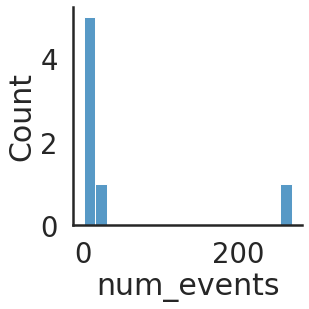

In [109]:
x = df0['num_events']
plt.figure(figsize= (7,15))
sns.displot(x);

# Generate individual based mobility patterns and attributes
As we noted in the project  instructions, the focus of this analysis is to understand mobility patterns 
on individual users. Although, generating trips  and understanding their distribution is crucial for this project, due to time constraints, we will start with simple mobility metrics. Namely:
- **Radius of gyration(Rg):**  For a single day, Rg can be defined in simple terms as the maximum distance a user travels. We can then compute ```avg_Rg``` based on all Rg from the user's data. This metric ```avg_Rg``` is what we will compute.
- **Number of unique locations visited everyday:** As the name suggests, this is simply, the count of unique locations an individual visits everyday. Given multiple days data, we will compute the ```avg_locs_per_day```

In addition to the mobility metric above, we will report the ```number of days``` a user was activive which will help us understand how much we should trust user data. 

For this task, we will utilize functions in the ```mob_data_utils``` module which were already created to generate  the required metrics above. You can import ```mob_data_utils``` like this to use my code: 
```import mob_data_utils as ut```

## Define functions to generate user attributes

In [58]:
def get_basic_user_mob_attributes(df):
        """
        In this funciton, we generate some basic user attributes 
        to help further explore the data and also report on 
        individual mobility metrics.
        :param df: Pandas DataFrame of single user data
        :return:
        """
        # get, datecol, x(lon), y(lat) from the MISC_PROCESSING_PARAMS variable
        datetimecol = MISC_PROCESSING_PARAMS.get('datetime_col')
        x = MISC_PROCESSING_PARAMS.get('x')
        y = MISC_PROCESSING_PARAMS.get('y')
        
        day_dict = {'0':'Monday', '1':'Tuesday', '2':'Wednesday', '3':'Thursday', '4':'Friday', '5':'Saturday','6':'Sunday'}       
             
        
        # use if condition to 
        if  'date' not in df.columns:
            # add date column in case its not  there
            # use the datetimecol to achieve this
            df['date'] = df['datetime_col'].map(lambda x: day_dict[x]) #not true
        
        # get a list of all  days/dates in ascending order
        # first, sort the dates and then get only unique dates
        dates = np.unique(sorted(df['date'])) # not true
        # this dictionary will keep, for each, a count of unique locations visited
        # initialize this dict with dates as keys and values set to 0
        # you can use list comprehension idea though this is a dictionary
        # Hint, create a list  of unique dates when initializing this dict
        unique_locs_by_day =  dict.fromkeys(dates,0) #not true
        
        # create a dictionary just like above but this one will keep
        # maximum distance travelled for each day
        dates_dist = {i:j for i,j in zip(dates, [0]*len(dates))}  #{k: 0 for k in list(df['date'].unique())}
        
        # Loop through the dates_dist dictionary
        for i,j in dates_dist.items(): 
            # Filter the input df so that we only get data for this date
            dfd = df[df['date']==i]                                               #df[df['date'].isin([i])]

            # get number of unique locations for this day
            uniq_xy = ut.va_generate_unique_locs(df=dfd, x=x, y=y)
            # add to the unique_locs_by_day dict, this date based on how
            # you initialized your loop, the value is the number of
            # unique locations visited
            unique_locs_by_day[i]=j+len(uniq_xy)


            # distances travel
            if len(uniq_xy) > 1:
                dist_mtx = ut.va_distance_matrix(uniq_xy)
                # From the distance matrix above, get only columns with "to"
                # in it, use list comprehension with if condition
                
                req_cols = list([i for i in dist_mtx.columns if 'to' in i ])[0]
                
                # get max value from the distance matrix above
                # first, subset the dist_mtx DataDrame by selecting only req_cols
                # then, get values from the resulting DataFrame which you should
                # pass into np.max() function
                # put the resulting max value into the dates_dist dict with this 
                # date as key
                # this can be achieved in a single line of code or multiple lines
                dist_mtx = np.round(np.max(dist_mtx[req_cols]),2)
                dates_dist[i] = dist_mtx
            else:
                # if number of unique locations is less than or equal to 1
                # then set the value in the dates_dist dict accordingly
                 dates_dist[i]= 0
    
        return  dates_dist, unique_locs_by_day,len(dates)
        

In [59]:
get_basic_user_mob_attributes(dfu.toPandas())

({datetime.date(2018, 6, 29): 236.8,
  datetime.date(2018, 6, 30): 208.28,
  datetime.date(2018, 7, 1): 328.4,
  datetime.date(2018, 7, 2): 328.4,
  datetime.date(2018, 7, 3): 212.8,
  datetime.date(2018, 7, 4): 233.31,
  datetime.date(2018, 7, 5): 212.8,
  datetime.date(2018, 7, 6): 234.82,
  datetime.date(2018, 7, 7): 212.8,
  datetime.date(2018, 7, 8): 233.31,
  datetime.date(2018, 7, 9): 186.26,
  datetime.date(2018, 7, 10): 234.82,
  datetime.date(2018, 7, 11): 212.8,
  datetime.date(2018, 7, 12): 186.26,
  datetime.date(2018, 7, 13): 212.89},
 {datetime.date(2018, 6, 29): 58,
  datetime.date(2018, 6, 30): 67,
  datetime.date(2018, 7, 1): 69,
  datetime.date(2018, 7, 2): 71,
  datetime.date(2018, 7, 3): 71,
  datetime.date(2018, 7, 4): 68,
  datetime.date(2018, 7, 5): 66,
  datetime.date(2018, 7, 6): 68,
  datetime.date(2018, 7, 7): 70,
  datetime.date(2018, 7, 8): 72,
  datetime.date(2018, 7, 9): 69,
  datetime.date(2018, 7, 10): 71,
  datetime.date(2018, 7, 11): 68,
  datetime.d

In [60]:
link = '/home/user/Desktop/big data analytic/simulated_locs.csv'
link2 = '/home/user/Desktop/big data analytic/yellow_tripdata_2021-01.csv'

In [61]:
import mob_data_utils as ut

In [76]:
def generate_basic_user_attributes_with_pandas(df, outcsv, num_events_threshold=None):
    """
        In this funciton, we generate some basic user attributes 
        to help further explore the data and also report on 
        individual mobility metrics.
        :param df: Pandas DataFrame with multiple user data
        :return:
        """
    # get userid col name from  MISC_PROCESSING_PARAMS
    userid = MISC_PROCESSING_PARAMS.get('userid') #not true
    # generate a list of unique userid's
    user_list = list(df[userid].unique())
    # initialize an empty list to hold user  data
    user_data = []
    
    # Loop through all users and generate their attributes
    for user in user_list:
        
        # Filter the input df so that we only get data for this user
        df_user =  df[df[userid]==user]                                                   #  YOUR CODE
        
        if num_events_threshold:
            if df_user.shape[0] < num_events_threshold:
                continue
            else:
                # call the get_basic_user_mob_attributes function here
                a,b,c = get_basic_user_mob_attributes(df_user)
        else:
             # call the get_basic_user_mob_attributes function here
            a,b,c = get_basic_user_mob_attributes(df_user)
        
        # get the attributes
        # create a dictionary with the following keys: 'userid', 'usage_days', 'mean_locs_day'
        # use appropriate numpy functions to compute  mean as required and set them as values
        # in the dict
        user_att =  {'userid':user,'usage_days':len(a.keys()),'mean_locs_day':(mean(list(b.values()))),
                     'Radius of gyration(Rg)':max(list(a.values())),'avd_Rg':mean(list(a.values()))}
        # add user_att to the user_data list
        user_data.append(user_att)
    
    # create DataFrame using user_data and save it to file (2 lines of code)
    dataFrame = pd.DataFrame(user_data)
    dataFrame.to_csv(outcsv, index=False)
    return dataFrame

In [87]:
# CALL YOUR generate_basic_user_attributes_with_pandas() FUNCTION HERE, 
# FIRST, CONVERT THE DF FROM preprocess_cdrs_using_spark() TO PANDAS # should read csv file first, joinpath..
df = generate_basic_user_attributes_with_pandas(dfu.toPandas(), 'outcsv.csv', num_events_threshold=2)

,userid,usage_days,mean_locs_day,Radius of gyration(Rg),avd_Rg
0,7261062279775109855,9,1.888889,22.02,3.736667
1,2687653510006079318,7,1.285714,2.23,0.545714
2,5971295292071109327,11,1.909091,2.74,0.942727
3,1218527985218154304,2,1.000000,0.00,0.000000
4,1908313866676533161,12,1.666667,8.09,1.921667
...,...,...,...,...,...
730,1953131665943264093,3,1.000000,0.00,0.000000
731,1221632098301211317,1,1.000000,0.00,0.000000
732,4467554764147785754,1,1.000000,0.00,0.000000
733,9170332955633665019,7,1.000000,0.00,0.000000


## Create outputs from the CSV file of user attributes

In [104]:
df

,userid,usage_days,mean_locs_day,Radius of gyration(Rg),avd_Rg
0,7261062279775109855,9,1.888889,22.02,3.736667
1,2687653510006079318,7,1.285714,2.23,0.545714
2,5971295292071109327,11,1.909091,2.74,0.942727
3,1218527985218154304,2,1.000000,0.00,0.000000
4,1908313866676533161,12,1.666667,8.09,1.921667
...,...,...,...,...,...
730,1953131665943264093,3,1.000000,0.00,0.000000
731,1221632098301211317,1,1.000000,0.00,0.000000
732,4467554764147785754,1,1.000000,0.00,0.000000
733,9170332955633665019,7,1.000000,0.00,0.000000


### QUESTION-PART1: DEFINE A FUNCTION WITH FOLLOWING PROPERTIES:
- **Function name:** generate_outputs_from_csv()
- **Inputs:** csv file which you save from generate_basic_user_attributes_with_pandas function above
- **Inside the function:** use any plotting library (e.g., seaborn as we have used in this course) to generate a distribution plot of ```Radius of gyration(Rg)```.  Make sure your function shows the plot inline when it runs.
- **Function output:** The function doesnt have to return anything

### QUESTION-PART2: INTERPRET THE RESULTS
Write a few sentences to interpret the plot ```Radius of gyration(Rg)``` that you generated. Based on how it looks, do you think its normally distributed? 

In [88]:
def generate_outputs_from_csv(outcsv):
    
    df = pd.read_csv(outcsv)
    x = df['Radius of gyration(Rg)']
    
    plt.figure(figsize= (7,15))
    sns.distplot(x)
    plt.show();# A refaire

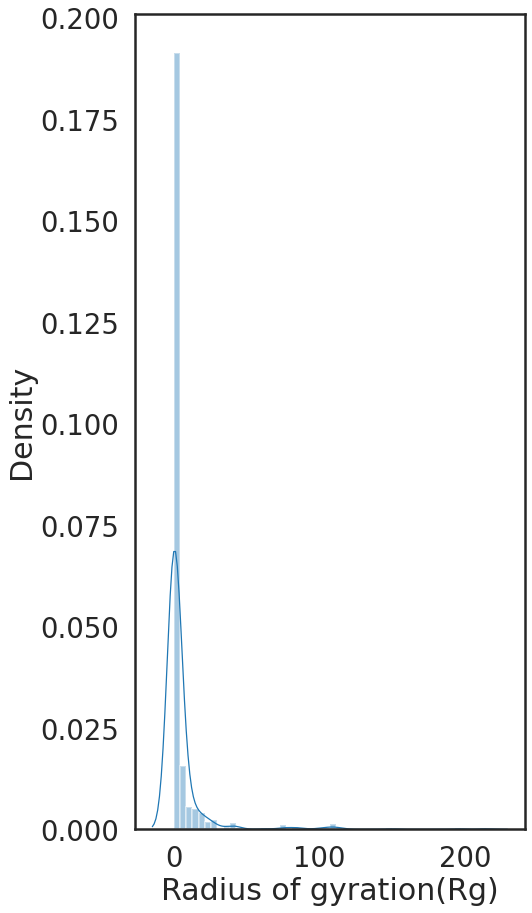

In [89]:
generate_outputs_from_csv('outcsv.csv')

## Interpretation


######  We observe from the plot above that the maximum distance made by the users can follow a normal distribution

### QUESTION: EXPLORE RELATIONSHIP BETWEEN ```avg_Rg``` and ```avg_locs_per_day```
Using the CSV that you saved above, perfom analyis (you dont have to use a function)
- Use a relevant plot to show relationship between the two variables
- Report the correlation coefficient between the two variables
- Write a few sentences to interpret the results

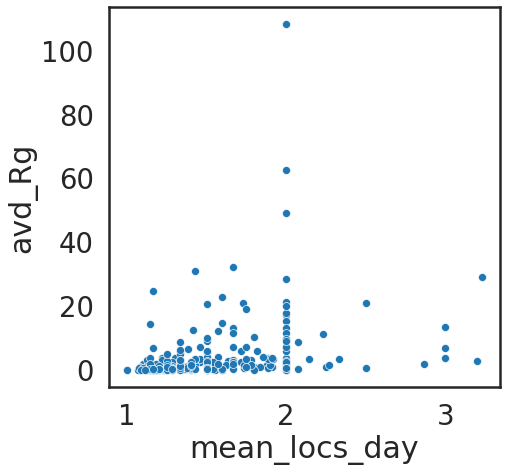

In [91]:
x = df['mean_locs_day']
y = df['avd_Rg']
plt.figure(figsize= (7,7))
#plt.plot(x,y)
sns.scatterplot(x,y)
plt.show()

# correlation coefficients

In [103]:
r = np.corrcoef(x, y)
r

array([[1.        , 0.41867642],
       [0.41867642, 1.        ]])

# interpretation of the results

#### We observe from the scatterplot of the two variables above that there is not a good linear relationship between the two variables and this is confirmed by the table of correlation above where we can see that the correlation coefficient between the average radius and the average location per day is ```0.41867642``` which is not close to one